<a href="https://colab.research.google.com/github/Leito2022/ProyectoHenryML/blob/main/proyectoHenry2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mlt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, fbeta_score
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

In [3]:
from sklearn.metrics import f1_score

#DESCRIPCION DE VARIABLE


-Available Extra Rooms in Hospital: Habitaciones adicionales disponibles en el 
hospital. Una habitación no es igual a un paciente, pueden ser individuales o compartidas.


-Department: Área de atención a la que ingresa el paciente.


-Ward_Facility_Code: Código de la habitación del paciente.


-doctor_name: Nombre de el/la doctor/a a cargo del paciente.


-staff_available: Cantidad de personal disponible al momento del ingreso del paciente.


-patientid: Identificador del paciente.


-Age: Edad del paciente.


-gender: Género del paciente.


-Type of Admission: Tipo de ingreso registrado según la situación de ingreso del paciente.


-Severity of Illness: Gravedad de la enfermedad/condición/estado del paciente al momento del ingreso.


-health_conditions: Condiciones de salud del paciente.


-Visitors with Patient: Cantidad de visitantes registrados para el paciente.


-Insurance: Indica si la persona posee o no seguro de salud.


-Admission_Deposit: Pago realizado a nombre del paciente, con el fin de cubrir los costos iniciales de internación.


-Stay (in days): Días registrados de estancia hospitalaria.​

# EDA

Realizo un EDA para encontrar nulos, valores extraños y outliers. Me adentro a la idea de que significa cada variable.

In [4]:
#Importamos los datasets

df = pd.read_csv("https://raw.githubusercontent.com/soyHenry/Datathon/main/hospitalizaciones_train.csv")
df_1 = pd.read_csv("https://raw.githubusercontent.com/soyHenry/Datathon/main/hospitalizaciones_test.csv")

In [5]:
#Agregamos la columna target (type_stay)

df["type_stay"] = np.where(df["Stay (in days)"] > 8, 1,0)

SELECCIÓN DE FEATURES

In [6]:
# Creamos una correlación de Pearson sobre las variables numericas

numeric_features = list(df.select_dtypes(np.number).columns) # Creamos lista de atributos numericos
df_numeric = df[numeric_features + ['type_stay']] # Cramos un dataframe con las columnas deseadas y la variable target

df_numeric.corr()

,Available Extra Rooms in Hospital,staff_available,patientid,Visitors with Patient,Admission_Deposit,Stay (in days),type_stay,type_stay
Available Extra Rooms in Hospital,1.000000,-0.003064,-0.005426,0.071073,-0.050775,-0.019383,0.053894,0.053894
staff_available,-0.003064,1.000000,-0.000350,0.001444,0.000816,0.006673,0.002883,0.002883
patientid,-0.005426,-0.000350,1.000000,-0.006393,0.011602,0.005567,-0.000532,-0.000532
Visitors with Patient,0.071073,0.001444,-0.006393,1.000000,-0.069566,0.027284,-0.009529,-0.009529
Admission_Deposit,-0.050775,0.000816,0.011602,-0.069566,1.000000,0.043899,-0.016650,-0.016650
Stay (in days),-0.019383,0.006673,0.005567,0.027284,0.043899,1.000000,0.493378,0.493378
type_stay,0.053894,0.002883,-0.000532,-0.009529,-0.016650,0.493378,1.000000,1.000000
type_stay,0.053894,0.002883,-0.000532,-0.009529,-0.016650,0.493378,1.000000,1.000000


Las correlaciones en las variables numéricas son bastante pobres, no me da certeza alguna de que pueda utilizar alguna de estas características. 

# Variables Categoricas


Procedo a analizar la correlación con las variables categóricas. Primero analizaré su distribución con respecto a la variable target de forma gráfica y luego calcularé el valor de chi 2.

In [7]:
categorical_features = list(df.select_dtypes(object).columns) # Creo lista de atributos categoricos
df_categ = df[categorical_features + ['type_stay']] # Creo un dataframe con las columnas deseadas y la variable target

categorical_features:     ['Department', 'Ward_Facility_Code', 'doctor_name', 'Age', 'gender', 'Type of Admission', 'Severity of Illness', 'health_conditions', 'Insurance']


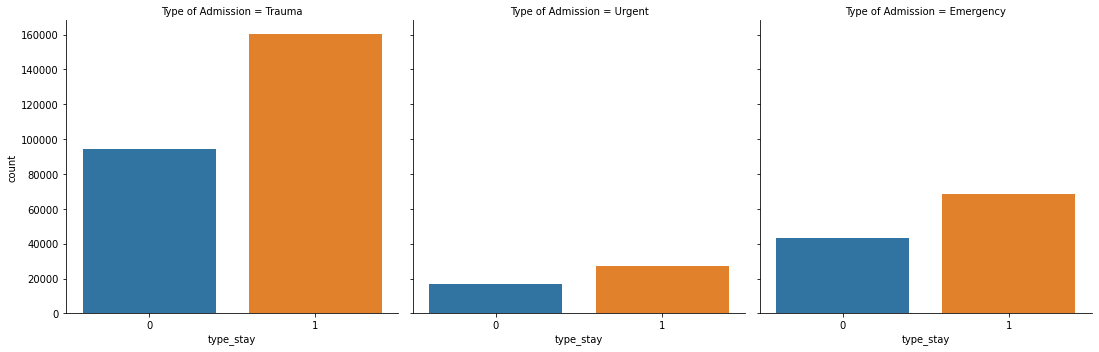

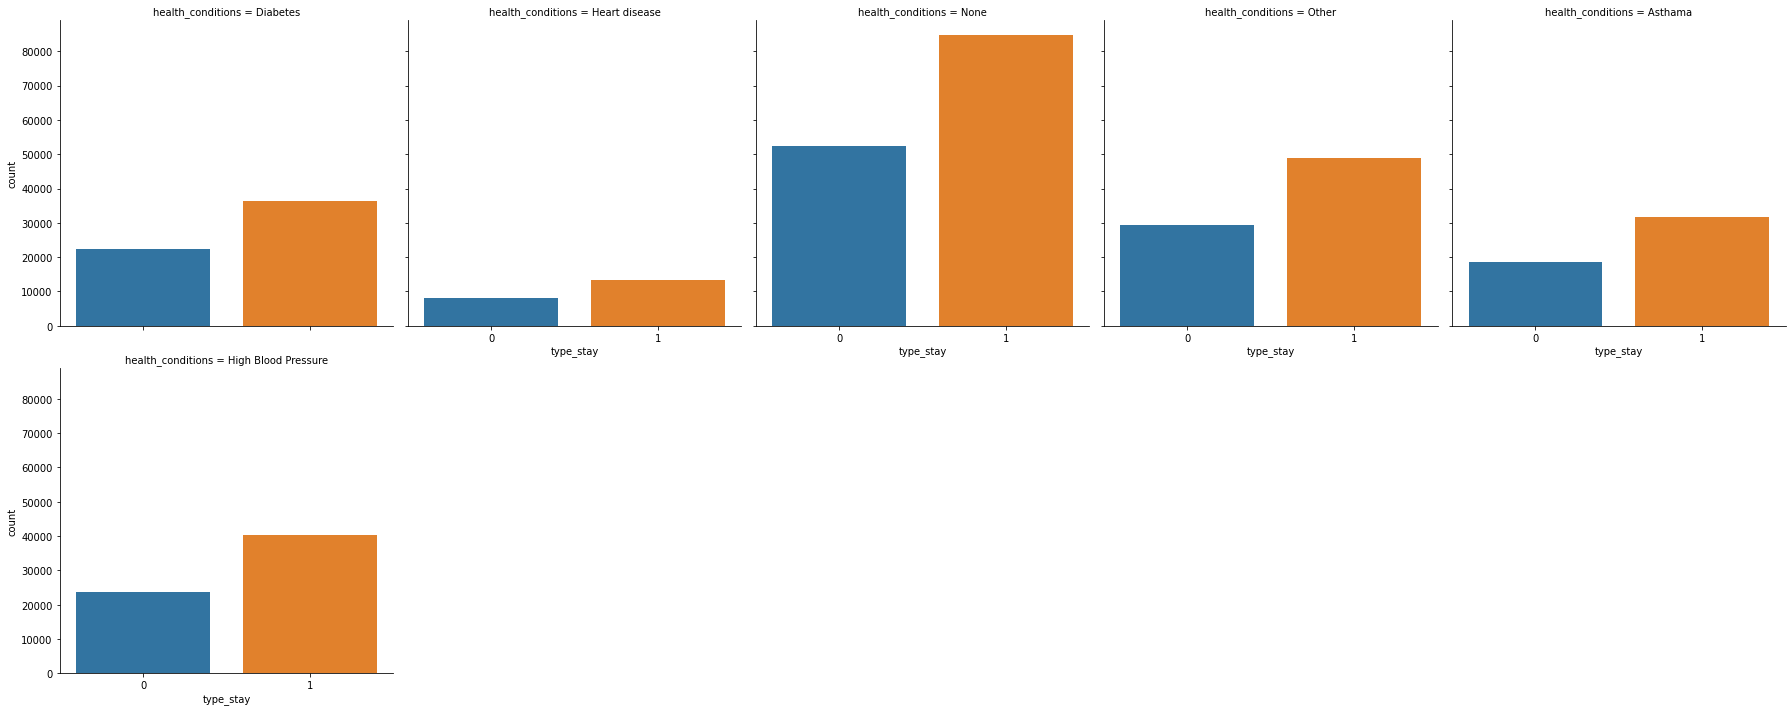

In [8]:
print('categorical_features:    ', categorical_features)

plot02 = sns.catplot(kind='count', x = "type_stay", col = 'Type of Admission', 
                     col_wrap = 5, data=df_categ, 
                     ) # Instanciamos pairplot

plot03 = sns.catplot(kind='count', x = "type_stay", col = "health_conditions", 
                     col_wrap = 5, data=df_categ, 
                     ) # Instanciamos pairplot

#Esto lo he realizado de a pares y observando todas las variables.
#Lamentablemente no hay una categoría que permita determinar una correlación en términos
#estadísticos, siempre hay que tener en cuenta que el nivel de proporción en el target
#es ligeramente desproporcionada, dando casi 65% a la internación de más de 8 días.

In [9]:
#Como vamos a aplicar modelos de clasificación debemos usar metodos acordes a ello
from sklearn.feature_selection import chi2
from sklearn.preprocessing	import OrdinalEncoder

enc = OrdinalEncoder()
df_categ.columns

Index(['Department', 'Ward_Facility_Code', 'doctor_name', 'Age', 'gender',
       'Type of Admission', 'Severity of Illness', 'health_conditions',
       'Insurance', 'type_stay'],
      dtype='object')

In [10]:
enc.fit(df_categ[['Department', 'Ward_Facility_Code', 'doctor_name', 'Age', 'gender',
       'Type of Admission', 'Severity of Illness', 'health_conditions',
       'Insurance', 'type_stay']])

OrdinalEncoder()

In [11]:
df_categ[['Department', 'Ward_Facility_Code', 'doctor_name', 'Age', 'gender',
       'Type of Admission', 'Severity of Illness', 'health_conditions',
       'Insurance', 'type_stay']] = enc.transform(df_categ[['Department', 'Ward_Facility_Code', 'doctor_name', 'Age', 'gender',
       'Type of Admission', 'Severity of Illness', 'health_conditions',
       'Insurance', 'type_stay']])

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [12]:
df_categ.head()

,Department,Ward_Facility_Code,doctor_name,Age,gender,Type of Admission,Severity of Illness,health_conditions,Insurance,type_stay
0,2.0,3.0,8.0,4.0,0.0,1.0,0.0,1.0,1.0,0.0
1,2.0,1.0,8.0,3.0,0.0,1.0,1.0,2.0,0.0,1.0
2,2.0,1.0,8.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0
3,2.0,3.0,4.0,3.0,0.0,2.0,2.0,4.0,0.0,0.0
4,1.0,4.0,2.0,7.0,1.0,1.0,2.0,1.0,0.0,1.0


In [13]:
df_categ.nunique()

Department              5
Ward_Facility_Code      6
doctor_name             9
Age                    10
gender                  3
Type of Admission       3
Severity of Illness     3
health_conditions       6
Insurance               2
type_stay               2
dtype: int64

In [14]:
X = df_categ.iloc[:,:9]
y = df_categ.iloc[:,-1]
y.head()

0    0.0
1    1.0
2    0.0
3    0.0
4    1.0
Name: type_stay, dtype: float64

In [43]:
df_train_test = pd.concat([df_categ.iloc[:,:9], df.select_dtypes(np.number)], axis = 1)

Modelo de regresión logística con todas las feature.

In [44]:
#Voy a probar regresión logística con todas las feature a excepción de patientid y Stay(in days)
df_regre_1 = df_train_test
df_regre_1.drop(["patientid","Admission_Deposit","Stay (in days)","Admission_Deposit"], axis = 1, inplace = True)

In [50]:
X = df_regre_1.iloc[:,:12]
y = df_regre_1.iloc[:,-1]

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 123)
# Estandarizamos los datos para que la regularización sea correcta
scaler = StandardScaler()
X_train_std = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_std = scaler.transform(X_test)

In [54]:
pd.DataFrame(y_test).value_counts(normalize=True)

type_stay
1            0.62278
0            0.37722
dtype: float64

In [55]:
pd.DataFrame(y_train).value_counts(normalize=True)

type_stay
1            0.623045
0            0.376955
dtype: float64

In [56]:
# Aplicamos un .describe() a ambos para ver los resultados de la estandarizacion de variables
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Department,287000.0,2.008958,0.692957,0.0,2.0,2.0,2.0,4.0
Ward_Facility_Code,287000.0,2.947052,1.690068,0.0,1.0,3.0,4.0,5.0
doctor_name,287000.0,4.422192,2.070179,0.0,3.0,4.0,6.0,8.0
Age,287000.0,3.125979,1.628524,0.0,2.0,3.0,4.0,9.0
gender,287000.0,0.313254,0.549715,0.0,0.0,0.0,1.0,2.0
Type of Admission,287000.0,0.835923,0.592732,0.0,0.0,1.0,1.0,2.0
Severity of Illness,287000.0,1.389213,0.765288,0.0,1.0,2.0,2.0,2.0
health_conditions,287000.0,3.011237,1.681518,0.0,1.0,4.0,4.0,5.0
Insurance,287000.0,0.830516,0.375180,0.0,1.0,1.0,1.0,1.0
Available Extra Rooms in Hospital,287000.0,3.643073,2.709457,0.0,2.0,3.0,4.0,24.0


In [57]:
#Instanciamos el modelo de Regresion logistica y lo entrenamos. Almacenamos las predicciones
lr = LogisticRegression(penalty='l2', 
                        class_weight='balanced'
                       )
lr.fit(X_train_std, y_train)

y_train_pred = lr.predict(X_train_std)

Accuracy del modelo de Reg. Logistica :    0.602
Recall del modelo de Reg. Logistica :      0.499
Rporte del modelo de Reg. Logistica :   
               precision    recall  f1-score   support

           0       0.48      0.77      0.59    108186
           1       0.78      0.50      0.61    178814

    accuracy                           0.60    287000
   macro avg       0.63      0.64      0.60    287000
weighted avg       0.67      0.60      0.60    287000



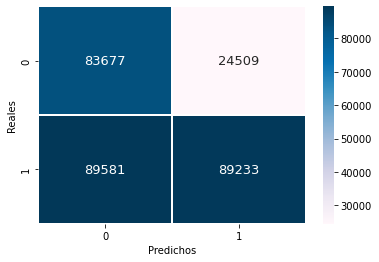

In [58]:
# Imprimimos resumen de metricas y la matriz de confusion

model_name = 'Reg. Logistica'

sns.heatmap(confusion_matrix(y_train, y_train_pred), annot=True, cmap='PuBu', fmt='0.0f', linewidths=0.25, 
           annot_kws={'size':13} )
plt.xlabel('Predichos')
plt.ylabel('Reales')

print('Accuracy del modelo de ' + model_name + ' :   ', accuracy_score(y_train, y_train_pred).round(3))
print('Recall del modelo de ' + model_name + ' :     ', recall_score(y_train, y_train_pred).round(3))

print('Rporte del modelo de ' + model_name + ' :   \n', classification_report(y_train, y_train_pred))

#Observamos que tenemos un recall de 0.50 y un recall de 0.60, procedo a eliminar más variable para ver si es posible mejorar el modelo.


In [63]:
df_regre_2 = df_train_test[["Age","gender","staff_available", 'Severity of Illness','Available Extra Rooms in Hospital','Department','Ward_Facility_Code','doctor_name','type_stay']]

In [81]:
df_regre_2.head()

,Age,gender,staff_available,Severity of Illness,Available Extra Rooms in Hospital,Department,Ward_Facility_Code,doctor_name,type_stay
0,4.0,0.0,0,0.0,4,2.0,3.0,8.0,0
1,3.0,0.0,2,1.0,4,2.0,1.0,8.0,1
2,2.0,0.0,8,0.0,2,2.0,1.0,8.0,0
3,3.0,0.0,7,2.0,4,2.0,3.0,4.0,0
4,7.0,1.0,10,2.0,2,1.0,4.0,2.0,1


In [ ]:
#Repetimos el proceso con el dataset más depurado

In [82]:
X = df_regre_2.iloc[:,:8]
y = df_regre_2.iloc[:,-1]

In [83]:
X.head()

,Age,gender,staff_available,Severity of Illness,Available Extra Rooms in Hospital,Department,Ward_Facility_Code,doctor_name
0,4.0,0.0,0,0.0,4,2.0,3.0,8.0
1,3.0,0.0,2,1.0,4,2.0,1.0,8.0
2,2.0,0.0,8,0.0,2,2.0,1.0,8.0
3,3.0,0.0,7,2.0,4,2.0,3.0,4.0
4,7.0,1.0,10,2.0,2,1.0,4.0,2.0


In [84]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 123)
# Estandarizamos los datos para que la regularización sea correcta
scaler = StandardScaler()
X_train_std = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_std = scaler.transform(X_test)

In [85]:
X_train.head()

,Age,gender,staff_available,Severity of Illness,Available Extra Rooms in Hospital,Department,Ward_Facility_Code,doctor_name
397558,3.0,0.0,5,2.0,21,2.0,3.0,8.0
146299,7.0,0.0,9,2.0,4,3.0,4.0,1.0
249328,3.0,0.0,7,2.0,3,2.0,1.0,6.0
38476,5.0,1.0,0,2.0,2,3.0,0.0,5.0
401702,2.0,0.0,10,1.0,4,2.0,5.0,3.0


In [87]:
#Instanciamos el modelo de Regresion logistica y lo entrenamos. Almacenamos las predicciones
lr = LogisticRegression(penalty='l2', 
                        class_weight='balanced'
                       )
lr.fit(X_train_std, y_train)

y_train_pred = lr.predict(X_train_std)

Accuracy del modelo de Reg. Logistica :    0.602
Recall del modelo de Reg. Logistica :      0.5
Rporte del modelo de Reg. Logistica :   
               precision    recall  f1-score   support

           0       0.48      0.77      0.59    108186
           1       0.78      0.50      0.61    178814

    accuracy                           0.60    287000
   macro avg       0.63      0.64      0.60    287000
weighted avg       0.67      0.60      0.60    287000



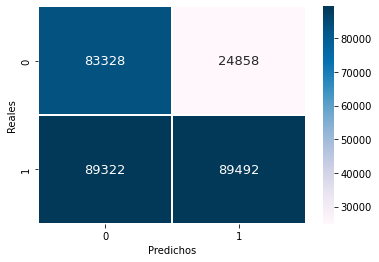

In [88]:
# Imprimimos resumen de metricas y la matriz de confusion

model_name = 'Reg. Logistica'

sns.heatmap(confusion_matrix(y_train, y_train_pred), annot=True, cmap='PuBu', fmt='0.0f', linewidths=0.25, 
           annot_kws={'size':13} )
plt.xlabel('Predichos')
plt.ylabel('Reales')

print('Accuracy del modelo de ' + model_name + ' :   ', accuracy_score(y_train, y_train_pred).round(3))
print('Recall del modelo de ' + model_name + ' :     ', recall_score(y_train, y_train_pred).round(3))

print('Rporte del modelo de ' + model_name + ' :   \n', classification_report(y_train, y_train_pred))

Sin resultados satisfactorios, procedo a probar Ada Boost


In [89]:
dtc = DecisionTreeClassifier(max_depth = 2, 
                             min_samples_split = 6)

ada = AdaBoostClassifier(base_estimator = dtc, 
                         n_estimators = 650,
                         learning_rate = 0.7)

In [90]:
ada.fit(X_train, y_train)

y_train_pred_ada = ada.predict(X_train)

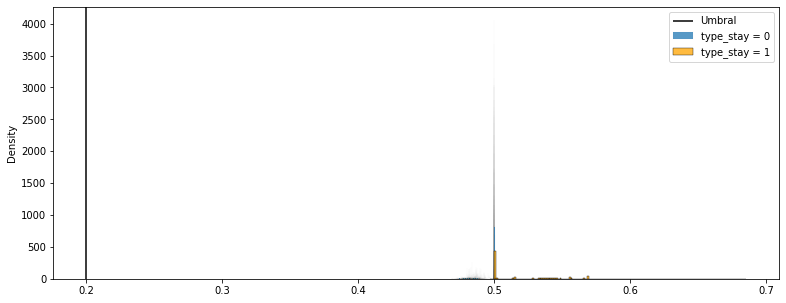

In [91]:
# Histograma de probabilidades
fig, ax01 = plt.subplots(1,1 , figsize=(13,5))
sns.histplot(data = ada.predict_proba(X_train[y_train==0])[:,1], stat = 'density', ax=ax01)
sns.histplot(data = ada.predict_proba(X_train[y_train==1])[:,1], stat = 'density', color = 'orange', ax=ax01)
ylim = plt.ylim()
plt.vlines(0.2, ylim[0], ylim[1])
plt.ylim(ylim)
plt.legend(['Umbral', 'type_stay = 0', 'type_stay = 1'])

In [92]:
umbral = 0.5
probs = ada.predict_proba(X_train)[:,1]
y_pred_train_ada_umbral = probs > umbral

Accuracy del modelo de AdaBoost:     0.699
Recall del modelo de AdaBoost:     0.861


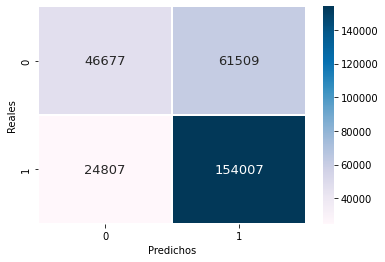

In [93]:
sns.heatmap(confusion_matrix(y_train, y_pred_train_ada_umbral), annot=True, cmap='PuBu', fmt='0.0f', linewidths=0.25, 
           annot_kws={'size':13} )
plt.xlabel('Predichos')
plt.ylabel('Reales')

print('Accuracy del modelo de AdaBoost:    ', accuracy_score(y_train, y_pred_train_ada_umbral).round(3))
print('Recall del modelo de AdaBoost:    ', recall_score(y_train, y_pred_train_ada_umbral).round(3))

Observemos el comportamiento en testeo


In [94]:
probs = ada.predict_proba(X_test)[:,1]
y_pred_test_ada_umbral = probs > umbral

Accuracy del modelo de AdaBoost (Testeo):     0.697
Recall del modelo de AdaBoost (Testeo):     0.86


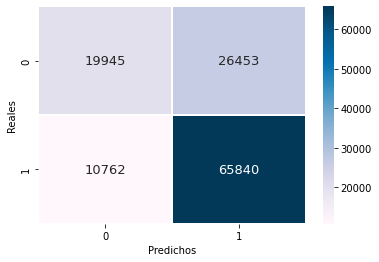

In [95]:
sns.heatmap(confusion_matrix(y_test, y_pred_test_ada_umbral), annot=True, cmap='PuBu', fmt='0.0f', linewidths=0.25, 
           annot_kws={'size':13} )
plt.xlabel('Predichos')
plt.ylabel('Reales')

print('Accuracy del modelo de AdaBoost (Testeo):    ', accuracy_score(y_test, y_pred_test_ada_umbral).round(3))
print('Recall del modelo de AdaBoost (Testeo):    ', recall_score(y_test, y_pred_test_ada_umbral).round(3))

Tenemos un nivel de Accuracy y Recall mejor que en el modelo de regresión lineal, por lo tanto intentaré mejorar los parametros para obtener mejores resultados.

# Optimización de hiperparámetros

In [96]:
dtc = DecisionTreeClassifier(max_depth = 6, 
                             min_samples_split = 6)

#lrc = LogisticRegression(penalty='l2', C=1.0, class_weight='balanced', solver='saga', tol=0.001, max_iter=1500)

ada = AdaBoostClassifier(base_estimator = dtc, 
                         n_estimators = 650,
                         learning_rate = 0.7)

In [97]:
param_grid = {'base_estimator__max_depth': [2, 3, 5],
              'base_estimator__min_samples_split': [6, 24, 96],
              'base_estimator__max_features': [None, 10, 6],
              'base_estimator__class_weight': [None, 'balanced'],
              'base_estimator__splitter': ["best", "random"],
              'n_estimators': [10, 30, 100],
              'learning_rate': [0.3, 0.5, 0.7]
             }

In [98]:
#scorer = make_scorer(fbeta_score, beta=4)

grid_obj = GridSearchCV(ada, param_grid, scoring = 'recall', n_jobs=-1, verbose=1, cv=3)

In [99]:
grid_fit = grid_obj.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
972 fits failed out of a total of 2916.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
972 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_weight_boosting.py", line 486, in fit
    return super().fit(X, y, sample_weight)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_weight_boosting.py", line 145, in fit
    sample_weight, estimator_weight, estimator_error = self._boo

In [100]:
best_ada = grid_fit.best_estimator_
print(grid_fit.best_params_)
print(grid_fit.best_score_)
y_train_pred_ada_opt = best_ada.predict(X_train)
y_test_pred_ada_opt = best_ada.predict(X_test)

{'base_estimator__class_weight': None, 'base_estimator__max_depth': 2, 'base_estimator__max_features': None, 'base_estimator__min_samples_split': 6, 'base_estimator__splitter': 'best', 'learning_rate': 0.3, 'n_estimators': 10}
0.9999888152559908


Accuracy del modelo de AdaBoost optimizado:     0.688
Recall del modelo de AdaBoost optimizado:     1.0


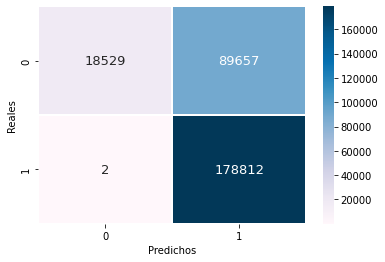

In [101]:
sns.heatmap(confusion_matrix(y_train, y_train_pred_ada_opt), annot=True, cmap='PuBu', fmt='0.0f', linewidths=0.25, 
           annot_kws={'size':13} )
plt.xlabel('Predichos')
plt.ylabel('Reales')

print('Accuracy del modelo de AdaBoost optimizado:    ', accuracy_score(y_train, y_train_pred_ada_opt).round(3))
print('Recall del modelo de AdaBoost optimizado:    ', recall_score(y_train, y_train_pred_ada_opt).round(3))

Accuracy del modelo de AdaBoost optimizado (Testeo):     0.688
Recall del modelo de AdaBoost optimizado (Testeo):       1.0


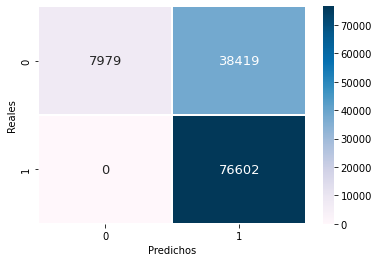

In [102]:
sns.heatmap(confusion_matrix(y_test, y_test_pred_ada_opt), annot=True, cmap='PuBu', fmt='0.0f', linewidths=0.25, 
           annot_kws={'size':13} )
plt.xlabel('Predichos')
plt.ylabel('Reales')

print('Accuracy del modelo de AdaBoost optimizado (Testeo):    ', accuracy_score(y_test, y_test_pred_ada_opt).round(3))
print('Recall del modelo de AdaBoost optimizado (Testeo):      ', recall_score(y_test, y_test_pred_ada_opt).round(3))

In [109]:
#Pasamos el modelo entrenado al dataset 2
#Convertimos las variables categ del set 2 a números para que lo lea el predictor.

categorical_features2 = list(df_1.select_dtypes(object).columns) # Creo lista de atributos categoricos
df_categ2 = df_1[categorical_features2] # Creo un dataframe con las columnas deseadas y la variable target




In [110]:
enc = OrdinalEncoder()
df_categ2.columns


Index(['Department', 'Ward_Facility_Code', 'doctor_name', 'Age', 'gender',
       'Type of Admission', 'Severity of Illness', 'health_conditions',
       'Insurance'],
      dtype='object')

In [112]:
enc.fit(df_categ2[['Department', 'Ward_Facility_Code', 'doctor_name', 'Age', 'gender',
       'Type of Admission', 'Severity of Illness', 'health_conditions',
       'Insurance']])

OrdinalEncoder()

In [114]:
df_categ2[['Department', 'Ward_Facility_Code', 'doctor_name', 'Age', 'gender',
       'Type of Admission', 'Severity of Illness', 'health_conditions',
       'Insurance']] = enc.transform(df_categ2[['Department', 'Ward_Facility_Code', 'doctor_name', 'Age', 'gender',
       'Type of Admission', 'Severity of Illness', 'health_conditions',
       'Insurance']])

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [115]:
df_categ2.head()

,Department,Ward_Facility_Code,doctor_name,Age,gender,Type of Admission,Severity of Illness,health_conditions,Insurance
0,2.0,5.0,4.0,2.0,0.0,1.0,2.0,5.0,0.0
1,0.0,4.0,1.0,5.0,0.0,1.0,2.0,0.0,1.0
2,3.0,4.0,1.0,5.0,2.0,1.0,2.0,4.0,0.0
3,2.0,5.0,4.0,2.0,0.0,1.0,2.0,4.0,1.0
4,1.0,0.0,1.0,5.0,0.0,1.0,0.0,1.0,0.0


In [116]:
df_concatenado2 = pd.concat([df_categ2, df_1.select_dtypes(np.number)], axis = 1)

In [117]:
df_concatenado2.head()

,Department,Ward_Facility_Code,doctor_name,Age,gender,Type of Admission,Severity of Illness,health_conditions,Insurance,Available Extra Rooms in Hospital,staff_available,patientid,Visitors with Patient,Admission_Deposit
0,2.0,5.0,4.0,2.0,0.0,1.0,2.0,5.0,0.0,3,10,2858,2,4749.640225
1,0.0,4.0,1.0,5.0,0.0,1.0,2.0,0.0,1.0,2,4,65657,2,4122.261324
2,3.0,4.0,1.0,5.0,2.0,1.0,2.0,4.0,0.0,2,7,45598,3,5459.067882
3,2.0,5.0,4.0,2.0,0.0,1.0,2.0,4.0,1.0,2,1,31132,2,3987.033318
4,1.0,0.0,1.0,5.0,0.0,1.0,0.0,1.0,0.0,2,7,125021,2,4770.789695


In [118]:
#Creo la variable x_testeo_final 

x_testeo_final = df_concatenado2[["Age","gender","staff_available", 'Severity of Illness','Available Extra Rooms in Hospital','Department','Ward_Facility_Code','doctor_name']]

In [119]:
#Usamos el predictor que creé sobre el dataset de testeo
prediccion_df2 = best_ada.predict(x_testeo_final)

In [123]:
print(prediccion_df2)

[1 1 1 ... 1 1 1]


In [136]:
resultado = pd.DataFrame(prediccion_df2)
resultado.set_axis(["pred"], axis = 1,inplace = True)

In [137]:
resultado.to_csv("Leito2022.csv", index = False)

In [16]:
df_train_test.drop(["patientid","Admission_Deposit","Stay (in days)","Admission_Deposit"], axis = 1)


,Department,Ward_Facility_Code,doctor_name,Age,gender,Type of Admission,Severity of Illness,health_conditions,Insurance,type_stay,Available Extra Rooms in Hospital,staff_available,Visitors with Patient,type_stay
0,2.0,3.0,8.0,4.0,0.0,1.0,0.0,1.0,1.0,0.0,4,0,4,0
1,2.0,1.0,8.0,3.0,0.0,1.0,1.0,2.0,0.0,1.0,4,2,2,1
2,2.0,1.0,8.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,2,8,2,0
3,2.0,3.0,4.0,3.0,0.0,2.0,2.0,4.0,0.0,0.0,4,7,4,0
4,1.0,4.0,2.0,7.0,1.0,1.0,2.0,1.0,0.0,1.0,2,10,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409995,2.0,3.0,6.0,3.0,0.0,1.0,1.0,0.0,1.0,0.0,1,1,3,0
409996,2.0,3.0,3.0,2.0,0.0,1.0,0.0,5.0,0.0,1.0,5,5,4,1
409997,2.0,3.0,6.0,2.0,0.0,0.0,1.0,0.0,1.0,1.0,4,9,4,1
409998,2.0,3.0,4.0,2.0,0.0,1.0,2.0,5.0,1.0,1.0,10,10,2,1


Depuramos una tabla con las features seleccionadas.

In [17]:
df_train_test.head()

,Department,Ward_Facility_Code,doctor_name,Age,gender,Type of Admission,Severity of Illness,health_conditions,Insurance,type_stay,Available Extra Rooms in Hospital,staff_available,patientid,Visitors with Patient,Admission_Deposit,Stay (in days),type_stay
0,2.0,3.0,8.0,4.0,0.0,1.0,0.0,1.0,1.0,0.0,4,0,33070,4,2966.408696,8,0
1,2.0,1.0,8.0,3.0,0.0,1.0,1.0,2.0,0.0,1.0,4,2,34808,2,3554.835677,9,1
2,2.0,1.0,8.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,2,8,44577,2,5624.733654,7,0
3,2.0,3.0,4.0,3.0,0.0,2.0,2.0,4.0,0.0,0.0,4,7,3695,4,4814.149231,8,0
4,1.0,4.0,2.0,7.0,1.0,1.0,2.0,1.0,0.0,1.0,2,10,108956,2,5169.269637,34,1


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 123)

In [19]:
f_score = chi2(X_train, y_train)

In [20]:
f_score

(array([2.03933258e+03, 1.56258888e+03, 8.17567621e+03, 1.29578211e+04,
        1.04182830e+04, 4.87687764e+00, 3.77185632e+01, 1.76373362e+00,
        2.31462330e-01]),
 array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 2.72188133e-02, 8.17231621e-10, 1.84159497e-01,
        6.30441646e-01]))

In [21]:
p_values = pd.Series(f_score[1])
p_values.index = X_train.columns
p_values

Department             0.000000e+00
Ward_Facility_Code     0.000000e+00
doctor_name            0.000000e+00
Age                    0.000000e+00
gender                 0.000000e+00
Type of Admission      2.721881e-02
Severity of Illness    8.172316e-10
health_conditions      1.841595e-01
Insurance              6.304416e-01
dtype: float64

In [22]:
# De lo observado, vemos que resulta dificil realizar la selección de características mediante
# correlación de Pearson o incluso con chi2, por lo que vamos a tomar las siguientes variables.
# healt_conditions

# Regresión Logística

In [23]:
# Preparamos la matriz de features y el vector objetivo
X = df.drop(columns=['type_stay'])
y = df['type_stay']

# Separamos un set de testeo para evaluar el modelo
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 0)

# Estandarizamos los datos para que la regularización sea correcta
scaler = StandardScaler()
#X_train_std = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
#X_test_std = scaler.transform(X_test)

KeyError: ignored

In [ ]:
#Instanciamos el modelo de Regresion logistica y lo entrenamos. Almacenamos las predicciones
lr = LogisticRegression(penalty='l2', 
                        class_weight='balanced'
                       )
lr.fit(X_train, y_train)

y_train_pred = lr.predict(X_train)